<a href="https://colab.research.google.com/github/sushirito/Methylmercury/blob/main/PHREEQC_PaperReplication.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install phreeqpy

In [2]:
import urllib.request
import phreeqpy.iphreeqc.phreeqc_dll as phreeqc_mod
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Constants and Configuration
CAP_THICKNESS = 1.0  # meters
NUM_CELLS = 100
CELL_LENGTH = CAP_THICKNESS / NUM_CELLS
POROSITY = 0.4
DIFFUSION_COEFFICIENT = 3e-10  # m^2/s
HYDRAULIC_CONDUCTIVITY = 1e-6  # m/s
ADVECTIVE_FLOW_RATE = 0.1 / (365 * 24 * 3600)  # m/year converted to m/s
SIMULATION_TIME = 10 * 365 * 24 * 3600  # 50 years in seconds
TIME_STEP = 365 * 24 * 3600  # 1 year in seconds
SHIFTS = SIMULATION_TIME // TIME_STEP

In [3]:
# Download the IPhreeqc Library and database
urllib.request.urlretrieve('https://github.com/rispr/phreeqc_web/blob/main/Iphreeqc_compiled/libiphreeqc-3.7.3.so?raw=true', 'libiphreeqc.dll')
lib = '/content/libiphreeqc.dll'

import os

# Function to load and read the database
def get_database(dbName):
  urllib.request.urlretrieve('https://raw.githubusercontent.com/rispr/phreeqc_web/main/database/'+ dbName, dbName)
  # If not using Google Colab the directory will be different
  dbase = '/content/' + dbName
  return dbase

# Function to read and run the input Iphreeqc script
def runPhreeqcSim(lib, dbase, pqc_input):
    phreeqc = phreeqc_mod.IPhreeqc(lib)
    phreeqc.load_database(dbase)
    phreeqc.run_string(pqc_input)
    phreeqc.set_output_file_on()
    return phreeqc
# Download and get the path for the database
dbase = get_database('llnl.dat')

# Initialize PHREEQC
iphreeqc = phreeqc_mod.IPhreeqc(lib)
iphreeqc.load_database(dbase)

def get_phreeqc_components():
    return lib, dbase

In [4]:
def create_solution_block(solution_number, conditions):
    return f"""
SOLUTION {solution_number}
    units mol/kgw
    temp 25
    pH {conditions['pH']}
    pe {conditions['pe']}
    As {conditions['As']}
    Hg {conditions['Hg']}
    C {conditions['C']}
    Ca {conditions['Ca']}
    Cl {conditions['Cl']}
    Fe {conditions['Fe']}
    N {conditions['N']}
    Na {conditions['Na']}
    S {conditions['S']}
    Si {conditions['Si']}
    -water 1 # kg
"""

def create_transport_block():
    return f"""
TRANSPORT
    -cells                 {NUM_CELLS}
    -lengths               {CELL_LENGTH}
    -time_step             {TIME_STEP}
    -shifts                {SHIFTS}
    -diffusion_coefficient {DIFFUSION_COEFFICIENT}
    -dispersivities        0
    -correct_disp          true
    -multi_d               true
    -interlayer_d          false
    -porosities            {POROSITY}
    -print_frequency       1
    -punch_frequency       1
    -boundary_conditions   flux flux
"""

def create_kinetics_block():
    # This is a placeholder. You need to implement the kinetic reactions from Table 4.
    return """
KINETICS 1-100
    # Add kinetic reactions here
RATES
    # Add rate expressions here
"""

In [5]:
def create_phreeqc_input():
    initial_conditions = {
        "pH": 8.0, "pe": 12.6,
        "As": 0.000126, "Hg": 5.01e-8, "C": 0.000794,
        "Ca": 0.01, "Cl": 0.1, "Fe": 0.000000501,
        "N": 0.00001, "Na": 0.1, "S": 0.01, "Si": 0.0001
    }

    lower_boundary = {
        "pH": 7.0, "pe": -2.5,
        "As": 0.000126, "Hg": 5.01e-8, "C": 0.0000316,
        "Ca": 0.00025, "Cl": 0.001, "Fe": 0.00000251,
        "N": 1e-8, "Na": 0.000501, "S": 0.00001, "Si": 0.0001
    }

    phreeqc_input = create_solution_block(0, initial_conditions)  # Upper boundary
    phreeqc_input += create_solution_block("1-100", initial_conditions)  # Initial porewater
    phreeqc_input += create_solution_block(101, lower_boundary)  # Lower boundary
    phreeqc_input += create_transport_block()
    phreeqc_input += create_kinetics_block()
    phreeqc_input += """
SELECTED_OUTPUT
    -file                  cap_simulation.csv
    -reset                 false
    -solution              true
    -distance              true
    -time                  true
    -pH                    true
    -pe                    true
    -alkalinity            true
    -ionic_strength        true
    -water                 true
    -charge_balance        true
    -percent_error         true
    -totals                As Hg Fe S Si
    -molalities            As(3) As(5) Hg(OH)2 HgS2-2 FeOH2+ Fe+2 HS- SO4-2 H4SiO4
    -equilibrium_phases    Goethite Mackinawite Pyrite Realgar Orpiment HgS
"""
    return phreeqc_input

In [6]:
def run_simulation(lib, dbase):
    phreeqc_input = create_phreeqc_input()
    phreeqc = runPhreeqcSim(lib, dbase, phreeqc_input)
    results = phreeqc.get_selected_output_array()
    df = pd.DataFrame(results[1:], columns=results[0])
    print("Columns in the results DataFrame:", df.columns)
    print("Unique time values:", df['time'].unique())
    print("Shape of results DataFrame:", df.shape)
    return df

def plot_results(df, species):
    plt.figure(figsize=(12, 8))
    distance_col = 'dist_x'
    species_col = f'{species}(mol/kgw)'
    time_col = 'time'

    if distance_col not in df.columns or species_col not in df.columns or time_col not in df.columns:
        print(f"Error: Required columns ('{distance_col}', '{species_col}', or '{time_col}') not found in the DataFrame.")
        print("Available columns:", df.columns)
        return

    # Convert time to years for better readability
    df['time_years'] = df[time_col] / (365 * 24 * 3600)

    # Create a colormap based on time
    unique_times = df['time_years'].unique()
    colormap = plt.cm.viridis(np.linspace(0, 1, len(unique_times)))

    for time, color in zip(unique_times, colormap):
        time_data = df[df['time_years'] == time]
        # Filter out zero or negative values for log scale
        valid_data = time_data[(time_data[distance_col] > 0) & (time_data[species_col] > 0)]
        if not valid_data.empty:
            plt.plot(valid_data[distance_col], valid_data[species_col], color=color, label=f'Year {time:.2f}')
        else:
            print(f"No valid positive data for Year {time:.2f}")

    plt.xlabel('Distance (m)')
    plt.ylabel(f'{species} concentration (mol/kgw)')
    plt.title(f'{species} concentration profile over time')

    # Use a colorbar instead of a legend for continuous time representation
    sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=df['time_years'].min(), vmax=df['time_years'].max()))
    sm.set_array([])
    cbar = plt.colorbar(sm)
    cbar.set_label('Time (years)')

    # Only use log scale if there are positive values
    if df[species_col].max() > 0:
        plt.yscale('log')
    else:
        print(f"Warning: No positive values for {species}, using linear scale")

    plt.show()

    # Print some statistics about the data
    print(f"\nStatistics for {species}:")
    print(df[species_col].describe())

    # Additional analysis
    print(f"\nUnique time values (years):")
    print(sorted(df['time_years'].unique()))

    print(f"\nConcentration range for {species}:")
    print(f"Min: {df[species_col].min()}")
    print(f"Max: {df[species_col].max()}")

    # Check for zero or negative values
    zero_neg_count = df[df[species_col] <= 0][species_col].count()
    print(f"\nNumber of zero or negative values for {species}: {zero_neg_count}")
    if zero_neg_count > 0:
        print("This may explain why some data points are not visible on the log-scale plot.")

PHREEQC components retrieved. Lib: /content/libiphreeqc.dll, Database: /content/llnl.dat
Columns in the results DataFrame: Index(['soln', 'dist_x', 'time', 'pH', 'pe', 'Alk(eq/kgw)', 'mu', 'mass_H2O',
       'charge(eq)', 'pct_err', 'As(mol/kgw)', 'Hg(mol/kgw)', 'Fe(mol/kgw)',
       'S(mol/kgw)', 'Si(mol/kgw)', 'm_As(3)(mol/kgw)', 'm_As(5)(mol/kgw)',
       'm_Hg(OH)2(mol/kgw)', 'm_HgS2-2(mol/kgw)', 'm_FeOH2+(mol/kgw)',
       'm_Fe+2(mol/kgw)', 'm_HS-(mol/kgw)', 'm_SO4-2(mol/kgw)',
       'm_H4SiO4(mol/kgw)', 'Goethite', 'd_Goethite', 'Mackinawite',
       'd_Mackinawite', 'Pyrite', 'd_Pyrite', 'Realgar', 'd_Realgar',
       'Orpiment', 'd_Orpiment', 'HgS', 'd_HgS'],
      dtype='object')
Unique time values: [-9.90000e+01  1.00000e+00  0.00000e+00  3.15360e+07  6.30720e+07
  9.46080e+07  1.26144e+08  1.57680e+08  1.89216e+08  2.20752e+08
  2.52288e+08  2.83824e+08  3.15360e+08]
Shape of results DataFrame: (1126, 36)
First few rows of the results DataFrame:
   soln  dist_x  time   pH 

<ipython-input-6-9f73e9fc39d7>:45: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


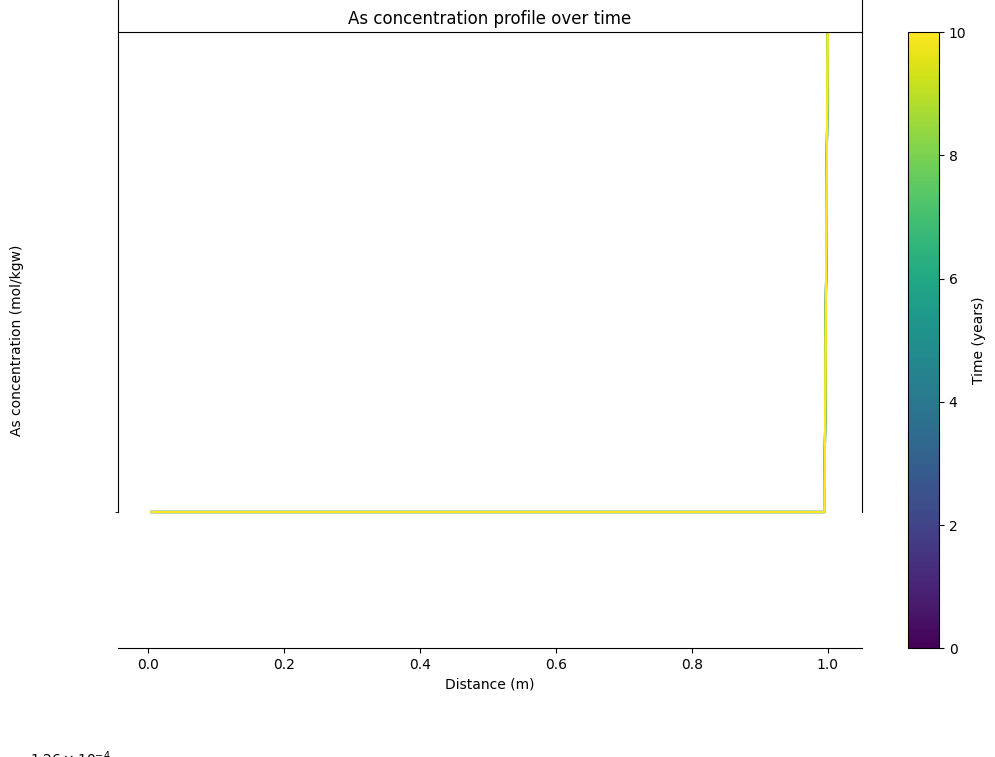


Statistics for As:
count    1.126000e+03
mean     1.260000e-04
std      3.177450e-20
min      1.260000e-04
25%      1.260000e-04
50%      1.260000e-04
75%      1.260000e-04
max      1.260000e-04
Name: As(mol/kgw), dtype: float64

Unique time values (years):
[-3.139269406392694e-06, 0.0, 3.1709791983764586e-08, 1.0, 2.0, 3.0, 4.0, 4.999999999999999, 5.999999999999999, 6.999999999999999, 7.999999999999999, 9.0, 10.0]

Concentration range for As:
Min: 0.00012600000000000003
Max: 0.00012600000000000022

Number of zero or negative values for As: 0
No valid positive data for Year -0.00
No valid positive data for Year 0.00


<ipython-input-6-9f73e9fc39d7>:45: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm)


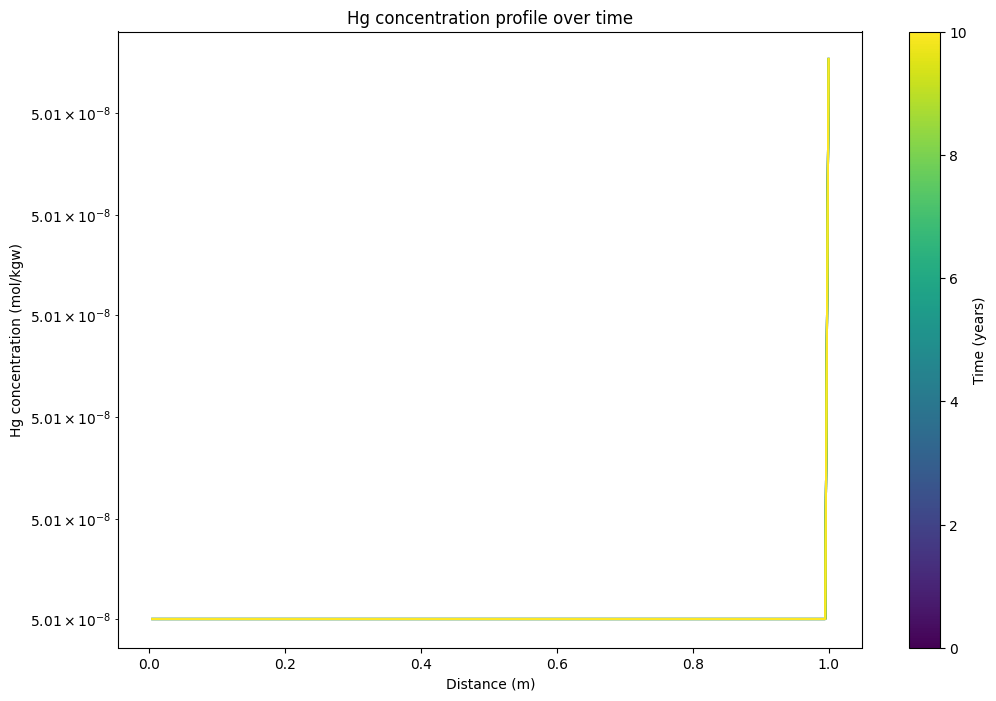


Statistics for Hg:
count    1.126000e+03
mean     5.010000e-08
std      5.442941e-21
min      5.010000e-08
25%      5.010000e-08
50%      5.010000e-08
75%      5.010000e-08
max      5.010000e-08
Name: Hg(mol/kgw), dtype: float64

Unique time values (years):
[-3.139269406392694e-06, 0.0, 3.1709791983764586e-08, 1.0, 2.0, 3.0, 4.0, 4.999999999999999, 5.999999999999999, 6.999999999999999, 7.999999999999999, 9.0, 10.0]

Concentration range for Hg:
Min: 5.0100000000000025e-08
Max: 5.0100000000055354e-08

Number of zero or negative values for Hg: 0


In [7]:
def main():
    try:
        lib, dbase = get_phreeqc_components()
        print(f"PHREEQC components retrieved. Lib: {lib}, Database: {dbase}")
        results = run_simulation(lib, dbase)
        print("First few rows of the results DataFrame:")
        print(results.head())
        plot_results(results, 'As')
        plot_results(results, 'Hg')
    except Exception as e:
        print(f"An error occurred in main: {str(e)}")
        import traceback
        traceback.print_exc()

if __name__ == "__main__":
    main()